In [ ]:
!pip install transformers datasets scikit-learn torch

In [ ]:
import torch, torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

In [ ]:
!pip install transformers datasets scikit-learn torch --quiet


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the sarcasm dataset
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection
!unzip -o news-headlines-dataset-for-sarcasm-detection.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 1.14GB/s]
Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
# Step 4: Load datasets
from datasets import load_dataset

sarcasm_ds = load_dataset("json", data_files="Sarcasm_Headlines_Dataset.json", split="train")
sarcasm_ds = sarcasm_ds.map(lambda x: {"text": x["headline"], "sarcasm": int(x["is_sarcastic"])})
sarcasm_ds = sarcasm_ds.remove_columns([c for c in sarcasm_ds.column_names if c not in ["text", "sarcasm"]])

emotion_ds = load_dataset("dair-ai/emotion", split="train")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(emotion_ds["label"])
emotion_ds = emotion_ds.map(lambda x: {"text": x["text"], "emotion": int(le.transform([x["label"]])[0])})
emotion_ds = emotion_ds.remove_columns(["label"])

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/26709 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [ ]:
# Step 5: Merge and split into train/validation
from datasets import Dataset

N = 10000
sarcasm_sample = sarcasm_ds.shuffle(seed=42).select(range(N))
emotion_sample = emotion_ds.shuffle(seed=42).select(range(N))

combined = Dataset.from_dict({
    "text": emotion_sample["text"] + sarcasm_sample["text"],
    "emotion": emotion_sample["emotion"] + [-1]*N,
    "sarcasm": [-1]*N + sarcasm_sample["sarcasm"]
})

split_ds = combined.train_test_split(test_size=0.1, seed=42)
train_ds = split_ds["train"]
val_ds = split_ds["test"]

In [ ]:
# Step 6: Tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "sarcasm", "emotion"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "sarcasm", "emotion"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Step 7: Define multitask model
import torch
import torch.nn as nn
from transformers import AutoModel

class MultiTaskModel(nn.Module):
    def __init__(self, n_emotions):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.sarcasm_head = nn.Linear(self.encoder.config.hidden_size, 2)
        self.emotion_head = nn.Linear(self.encoder.config.hidden_size, n_emotions)

    def forward(self, input_ids, attention_mask, sarcasm=None, emotion=None):
        x = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        x = self.dropout(x)
        logits_s = self.sarcasm_head(x)
        logits_e = self.emotion_head(x)
        loss = torch.tensor(0.).to(x.device)
        if sarcasm is not None and (sarcasm >= 0).any():
            weights = torch.tensor([0.3, 0.7]).to(x.device)  # Weighted loss to fight class imbalance
            loss += nn.CrossEntropyLoss(weight=weights)(logits_s[sarcasm >= 0], sarcasm[sarcasm >= 0])
        if emotion is not None and (emotion >= 0).any():
            loss += nn.CrossEntropyLoss()(logits_e[emotion >= 0], emotion[emotion >= 0])
        return {"loss": loss, "logits_s": logits_s, "logits_e": logits_e}


In [ ]:
# Step 8: TPU training loop with dual-metric early stopping
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

def train_on_tpu(rank, flags):
    device = xm.xla_device()
    model = MultiTaskModel(n_emotions=len(le.classes_)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=flags['lr'])

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=flags['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=flags['batch_size'])

    best_loss, best_acc, patience = float('inf'), 0, 0
    for epoch in range(flags['epochs']):
        model.train()
        total_loss = 0
        para_loader = pl.MpDeviceLoader(train_loader, device)
        for batch in para_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(batch["input_ids"], batch["attention_mask"], batch["sarcasm"], batch["emotion"])
            optimizer.zero_grad()
            out["loss"].backward()
            xm.optimizer_step(optimizer)
            total_loss += out["loss"].item()

        xm.master_print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f}")

        model.eval()
        total_loss, correct_s, total_s, correct_e, total_e = 0, 0, 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                out = model(batch["input_ids"], batch["attention_mask"], batch["sarcasm"], batch["emotion"])
                total_loss += out["loss"].item()
                pred_s = out["logits_s"].argmax(dim=1)
                pred_e = out["logits_e"].argmax(dim=1)
                mask_s = batch["sarcasm"] >= 0
                mask_e = batch["emotion"] >= 0
                correct_s += (pred_s[mask_s] == batch["sarcasm"][mask_s]).sum().item()
                correct_e += (pred_e[mask_e] == batch["emotion"][mask_e]).sum().item()
                total_s += mask_s.sum().item()
                total_e += mask_e.sum().item()

        val_loss = total_loss / len(val_loader)
        acc_s = correct_s / total_s if total_s else 0
        acc_e = correct_e / total_e if total_e else 0
        avg_acc = (acc_s + acc_e) / 2
        xm.master_print(f"Val | Loss: {val_loss:.4f} | Sarcasm Acc: {acc_s:.4f} | Emotion Acc: {acc_e:.4f}")

        if val_loss < best_loss and avg_acc > best_acc:
            best_loss, best_acc = val_loss, avg_acc
            xm.save(model.state_dict(), "multitask_tpu_model.pt")
            xm.master_print("Validation loss & accuracy improved. Saving model...")
            patience = 0
        else:
            patience += 1
            xm.master_print(f"⏸ No improvement. Patience = {patience}/{flags['patience']}")
            if patience >= flags['patience']:
                xm.master_print("Early stopping triggered.")
                break


In [ ]:
# Step 9: Launch training
FLAGS = {
    'epochs': 20,
    'batch_size': 16,
    'lr': 2e-5,
    'patience': 3
}

xmp.spawn(train_on_tpu, args=(FLAGS,), nprocs=1, start_method='fork')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.8744
Val | Loss: 0.4737 | Sarcasm Acc: 0.8883 | Emotion Acc: 0.9155
Validation loss & accuracy improved. Saving model...
Epoch 2: Train Loss = 0.3320
Val | Loss: 0.4389 | Sarcasm Acc: 0.9019 | Emotion Acc: 0.9196
Validation loss & accuracy improved. Saving model...
Epoch 3: Train Loss = 0.1833
Val | Loss: 0.4703 | Sarcasm Acc: 0.9049 | Emotion Acc: 0.9258
⏸ No improvement. Patience = 1/3
Epoch 4: Train Loss = 0.1223
Val | Loss: 0.5583 | Sarcasm Acc: 0.9029 | Emotion Acc: 0.9227
⏸ No improvement. Patience = 2/3
Epoch 5: Train Loss = 0.0913
Val | Loss: 0.7022 | Sarcasm Acc: 0.9058 | Emotion Acc: 0.9196
⏸ No improvement. Patience = 3/3
Early stopping triggered.


In [ ]:
# Step 10: Evaluate on validation set and collect labels
from torch.utils.data import DataLoader
import torch_xla.core.xla_model as xm

device = xm.xla_device()
model = MultiTaskModel(n_emotions=len(le.classes_)).to(device)
# Load the saved model state dictionary
model.load_state_dict(torch.load("multitask_tpu_model.pt"))
model.eval()

val_loader = DataLoader(val_ds, batch_size=FLAGS['batch_size'])

true_sarcasm = []
pred_sarcasm = []
true_emotion = []
pred_emotion = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(batch["input_ids"], batch["attention_mask"], batch["sarcasm"], batch["emotion"])

        # Collect sarcasm labels and predictions
        mask_s = batch["sarcasm"] >= 0
        true_sarcasm.extend(batch["sarcasm"][mask_s].cpu().numpy())
        pred_sarcasm.extend(out["logits_s"][mask_s].argmax(dim=1).cpu().numpy())

        # Collect emotion labels and predictions
        mask_e = batch["emotion"] >= 0
        true_emotion.extend(batch["emotion"][mask_e].cpu().numpy())
        pred_emotion.extend(out["logits_e"][mask_e].argmax(dim=1).cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

print("Sarcasm Classification Report")
print(classification_report(true_sarcasm, pred_sarcasm, target_names=["Not Sarcastic", "Sarcastic"]))

# Use correct emotion labels directly
target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print("\nEmotion Classification Report")
print(classification_report(true_emotion, pred_emotion, target_names=target_labels))


Sarcasm Classification Report
               precision    recall  f1-score   support

Not Sarcastic       0.91      0.90      0.91       557
    Sarcastic       0.89      0.90      0.89       473

     accuracy                           0.90      1030
    macro avg       0.90      0.90      0.90      1030
 weighted avg       0.90      0.90      0.90      1030


Emotion Classification Report
              precision    recall  f1-score   support

     sadness       0.97      0.95      0.96       283
         joy       0.96      0.92      0.94       322
        love       0.76      0.94      0.84        80
       anger       0.96      0.91      0.93       129
        fear       0.84      0.96      0.90       116
    surprise       0.94      0.75      0.83        40

    accuracy                           0.93       970
   macro avg       0.90      0.90      0.90       970
weighted avg       0.93      0.93      0.93       970



In [ ]:
import torch
from transformers import AutoTokenizer

# Load model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskModel(n_emotions=6)
model.load_state_dict(torch.load("multitask_tpu_model.pt", map_location=device))
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Emotion label names (from dair-ai/emotion)
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
sarcasm_labels = ['Not Sarcastic', 'Sarcastic']

# 👇 Function to run inference
def predict_sentences(sentences):
    encodings = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors="pt")
    encodings = {k: v.to(device) for k, v in encodings.items()}

    with torch.no_grad():
        outputs = model(encodings["input_ids"], encodings["attention_mask"])
        pred_sarcasm = torch.argmax(outputs["logits_s"], dim=1).cpu().numpy()
        pred_emotion = torch.argmax(outputs["logits_e"], dim=1).cpu().numpy()

    for i, text in enumerate(sentences):
        print(f"\nSentence: {text}")
        print(f"Emotion: {emotion_labels[pred_emotion[i]]}")
        print(f"Sarcasm: {sarcasm_labels[pred_sarcasm[i]]}")



In [ ]:
test_sentences = [
    "Oh great, another Monday morning meeting. Just what I needed!",
    "I’m so happy to see you again!",
    "Why don’t you just crash the car while you’re at it.",
    "That was the best gift I've ever received.",
    "Wow, I love being ignored by my friends.",
    "He finally asked me out! I'm so nervous!"
]

predict_sentences(test_sentences)




Sentence: Oh great, another Monday morning meeting. Just what I needed!
Emotion: joy
Sarcasm: Not Sarcastic

Sentence: I’m so happy to see you again!
Emotion: joy
Sarcasm: Not Sarcastic

Sentence: Why don’t you just crash the car while you’re at it.
Emotion: anger
Sarcasm: Not Sarcastic

Sentence: That was the best gift I've ever received.
Emotion: joy
Sarcasm: Not Sarcastic

Sentence: Wow, I love being ignored by my friends.
Emotion: sadness
Sarcasm: Not Sarcastic

Sentence: He finally asked me out! I'm so nervous!
Emotion: fear
Sarcasm: Not Sarcastic


In [ ]:
# prompt: f1
# score

from sklearn.metrics import f1_score, classification_report

# ... (previous code for loading model, data, etc.) ...

# Calculate F1 score for sarcasm
sarcasm_f1 = f1_score(true_sarcasm, pred_sarcasm, average='weighted') # or 'micro', 'macro'

# Calculate F1 score for emotion
emotion_f1 = f1_score(true_emotion, pred_emotion, average='weighted') # or 'micro', 'macro'


print("\nSarcasm F1 Score (weighted):", sarcasm_f1)
print("Emotion F1 Score (weighted):", emotion_f1)

# You can also get F1 scores from the classification report
sarcasm_report = classification_report(true_sarcasm, pred_sarcasm, target_names=["Not Sarcastic", "Sarcastic"], output_dict=True)
emotion_report = classification_report(true_emotion, pred_emotion, target_names=target_labels, output_dict=True)

print("\nSarcasm Report F1 Score:", sarcasm_report['weighted avg']['f1-score'])
print("Emotion Report F1 Score:", emotion_report['weighted avg']['f1-score'])



Sarcasm F1 Score (weighted): 0.901803210189701
Emotion F1 Score (weighted): 0.919354727387678

Sarcasm Report F1 Score: 0.901803210189701
Emotion Report F1 Score: 0.919354727387678


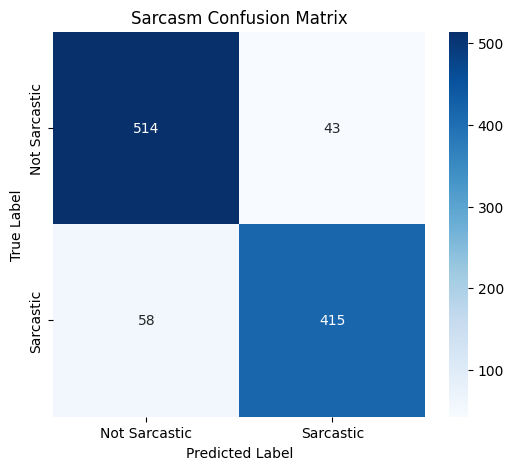

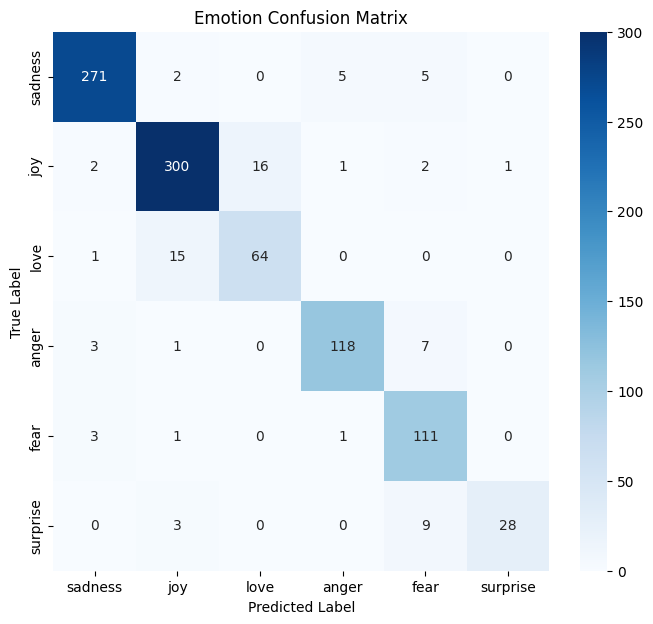

In [ ]:
# prompt: heatmap

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrices
conf_matrix_sarcasm = confusion_matrix(true_sarcasm, pred_sarcasm)
conf_matrix_emotion = confusion_matrix(true_emotion, pred_emotion)

# Plot Sarcasm Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_sarcasm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sarcasm_labels, yticklabels=sarcasm_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Sarcasm Confusion Matrix')
plt.show()

# Plot Emotion Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix_emotion, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Emotion Confusion Matrix')
plt.show()
